In [1]:
import breakwater as bw
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read Input

1. Hydraulic input conditions
2. Damage levels

#### Provide path of input excel file

In [2]:
#Path excel file
path = 'Excel_Files/Input_Energy_Island.xlsx'

In [3]:
df_input_hydraulic = pd.read_excel(path, sheet_name= 'Hydraulic_Design_Conditions')
df_input_damage = pd.read_excel(path, sheet_name= 'Design_Requirements')

In [4]:
df_input_hydraulic.head(3)

,Case_ID,DIR (deg_N),Hm0(m),Tp(s),ReturnPeriod(YR),Design high water level (LAT+m),Design low water level (LAT+m)
0,1,0,3.9,10.4,1,2.41,0
1,2,45,4.2,9.1,1,2.41,0
2,3,90,3.4,7.3,1,2.41,0


In [5]:
df_input_damage.head(3)

,ReturnPeriod(YR),"Damage Rock Armour accepted, S (-)",Damage Toe accepted NoD (-),Overtopping accepted q (l/s/m)
0,1,2,0.5,1
1,5,2,0.5,10
2,10,2,0.5,10


#### Choose a return period

In [6]:
RP = 1000

In [7]:
df_input_hydraulic = df_input_hydraulic[df_input_hydraulic['ReturnPeriod(YR)'] == RP].reset_index()
df_input_damage = df_input_damage[df_input_damage['ReturnPeriod(YR)'] == RP].reset_index()

#### Wave conditions

In [8]:
df_input_hydraulic

,index,Case_ID,DIR (deg_N),Hm0(m),Tp(s),ReturnPeriod(YR),Design high water level (LAT+m),Design low water level (LAT+m)
0,48,49,0,8.4,13.2,1000,3.41,0
1,49,50,45,8.8,11.8,1000,3.41,0
2,50,51,90,6.7,9.1,1000,3.41,0
3,51,52,135,7.5,10.1,1000,3.41,0
4,52,53,180,10.0,13.0,1000,3.41,0
5,53,54,225,11.4,13.8,1000,3.41,0
6,54,55,270,12.8,15.8,1000,3.41,0
7,55,56,315,13.1,17.0,1000,3.41,0


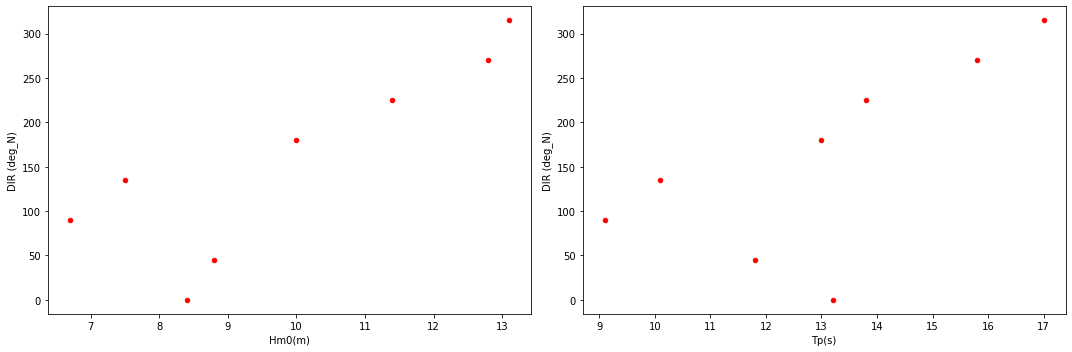

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

df_input_hydraulic.plot('Hm0(m)', 'DIR (deg_N)', color= 'r', kind= 'scatter', ax= ax1);
df_input_hydraulic.plot('Tp(s)', 'DIR (deg_N)', color= 'r', kind= 'scatter', ax= ax2);

fig.tight_layout()

#### Damage levels

In [10]:
df_input_damage

,index,ReturnPeriod(YR),"Damage Rock Armour accepted, S (-)",Damage Toe accepted NoD (-),Overtopping accepted q (l/s/m)
0,6,1000,4,3.0,100


In [11]:
Sd = df_input_damage['Damage Rock Armour accepted, S (-)'].values[0]
NoD = df_input_damage['Damage Toe accepted NoD (-)'].values[0]
q = df_input_damage['Overtopping accepted q (l/s/m)'].values[0]

## 3D shape

In [12]:
path = 'Energy Island rectangular.kml'

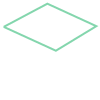

In [13]:
shape = bw.shape_3D(kml_path = path)
shape

In [14]:
wave_directions = {}

for index, row in df_input_hydraulic.iterrows():
    wave_directions[row['DIR (deg_N)']] = {'Hm0': row['Hm0(m)'], 'Tp': row['Tp(s)']}
    
wave_directions

{0.0: {'Hm0': 8.4, 'Tp': 13.2},
 45.0: {'Hm0': 8.8, 'Tp': 11.8},
 90.0: {'Hm0': 6.7, 'Tp': 9.1},
 135.0: {'Hm0': 7.5, 'Tp': 10.1},
 180.0: {'Hm0': 10.0, 'Tp': 13.0},
 225.0: {'Hm0': 11.4, 'Tp': 13.8},
 270.0: {'Hm0': 12.8, 'Tp': 15.8},
 315.0: {'Hm0': 13.1, 'Tp': 17.0}}

128.27289323522123
43.59308620144983
308.50467926712577
227.44561105191463


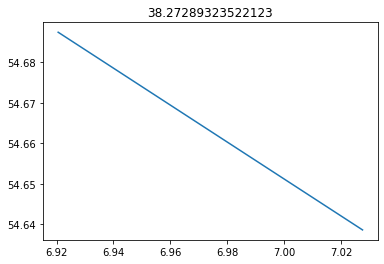

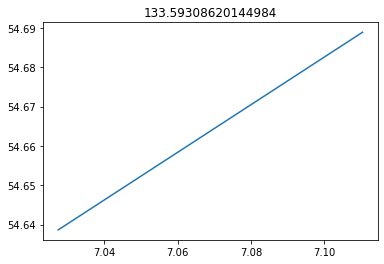

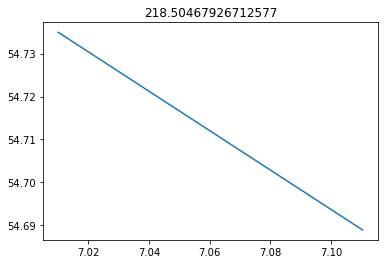

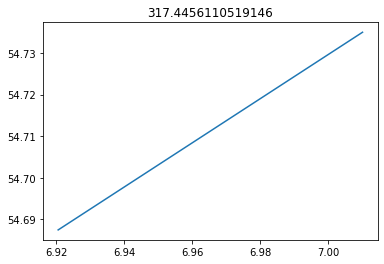

In [15]:
bw.governing_wave_direction(kml_path= path, wave_directions= wave_directions, shape= 'LinearRing')